In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from time import time

from keras.models import Model, Sequential
from keras.optimizers import Adam
import keras.backend as K
from keras.utils.generic_utils import Progbar

from model import *

/home/mathlab115/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# for resist GPU memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

In [3]:
from keras.datasets import cifar100, cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
X = np.concatenate((x_test,x_train))
X.shape

(60000, 32, 32, 3)

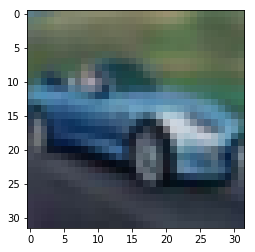

In [5]:
plt.imshow(X[9487])

In [6]:
#Hyperperemeter
BATCHSIZE=64
LEARNING_RATE = 0.0002
TRAINING_RATIO = 1
BETA_1 = 0.0
BETA_2 = 0.9
EPOCHS = 500
BN_MIMENTUM = 0.9
BN_EPSILON  = 0.00002
SAVE_DIR = 'img/generated_img_CIFAR10_ResNet/'

GENERATE_ROW_NUM = 8
GENERATE_BATCHSIZE = GENERATE_ROW_NUM*GENERATE_ROW_NUM

In [7]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

generator = BuildGenerator(bn_momentum=BN_MIMENTUM, bn_epsilon=BN_EPSILON)
discriminator = BuildDiscriminator()

Noise_input_for_training_generator = Input(shape=(128,))
Generated_image                    = generator(Noise_input_for_training_generator)
Discriminator_output               = discriminator(Generated_image)
model_for_training_generator       = Model(Noise_input_for_training_generator, Discriminator_output)
print("model_for_training_generator")
discriminator.trainable = False
model_for_training_generator.summary()
model_for_training_generator.compile(optimizer=Adam(LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2), loss=wasserstein_loss)

Generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              528384    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
Generator_resblock_1 (Model) (None, 8, 8, 256)         1248000   
_________________________________________________________________
Generator_resblock_2 (Model) (None, 16, 16, 256)       1248000   
_________________________________________________________________
Generator_resblock_3 (Model) (None, 32, 32, 256)       1248000   
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 256)       1024      


In [8]:
Real_image                             = Input(shape=(32,32,3))
Noise_input_for_training_discriminator = Input(shape=(128,))
Fake_image                             = generator(Noise_input_for_training_discriminator)
Discriminator_output_for_real          = discriminator(Real_image)
Discriminator_output_for_fake          = discriminator(Fake_image)

model_for_training_discriminator       = Model([Real_image,
                                                Noise_input_for_training_discriminator],
                                               [Discriminator_output_for_real,
                                                Discriminator_output_for_fake])
print("model_for_training_discriminator")
generator.trainable = False
discriminator.trainable = True
model_for_training_discriminator.compile(optimizer=Adam(LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2), loss=[wasserstein_loss, wasserstein_loss])
model_for_training_discriminator.summary()

model_for_training_discriminator
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_12 (InputLayer)            (None, 128)           0                                            
____________________________________________________________________________________________________
input_11 (InputLayer)            (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
Generator (Model)                (None, 32, 32, 3)     4280323     input_12[0][0]                   
____________________________________________________________________________________________________
Discriminator (Model)            (None, 1)             1086849     input_11[0][0]                   
                                                          

In [11]:
real_y = np.ones((BATCHSIZE, 1), dtype=np.float32)
fake_y = -real_y

In [10]:
X = X/255*2-1

In [ ]:
test_noise = np.random.randn(GENERATE_BATCHSIZE, 128)
W_loss = []
discriminator_loss = []
generator_loss = []
for epoch in range(EPOCHS):
    np.random.shuffle(X)
    
    print("epoch {} of {}".format(epoch+1, EPOCHS))
    num_batches = int(X.shape[0] // BATCHSIZE)
    
    print("number of batches: {}".format(int(X.shape[0] // (BATCHSIZE))))
    
    progress_bar = Progbar(target=int(X.shape[0] // (BATCHSIZE * TRAINING_RATIO)))
    minibatches_size = BATCHSIZE * TRAINING_RATIO
    
    start_time = time()
    for index in range(int(X.shape[0] // (BATCHSIZE * TRAINING_RATIO))):
        progress_bar.update(index)
        discriminator_minibatches = X[index * minibatches_size:(index + 1) * minibatches_size]
        
        for j in range(TRAINING_RATIO):
            image_batch = discriminator_minibatches[j * BATCHSIZE : (j + 1) * BATCHSIZE]
            noise = np.random.randn(BATCHSIZE, 128).astype(np.float32)
            discriminator.trainable = True
            generator.trainable = False
            discriminator_loss.append(model_for_training_discriminator.train_on_batch([image_batch, noise],
                                                                                      [real_y, fake_y]))
        discriminator.trainable = False
        generator.trainable = True
        generator_loss.append(model_for_training_generator.train_on_batch(np.random.randn(BATCHSIZE, 128), real_y))
    
    print('\nepoch time: {}'.format(time()-start_time))
    
    W_real = model_for_training_generator.evaluate(test_noise, real_y)
    print(W_real)
    W_fake = model_for_training_generator.evaluate(test_noise, fake_y)
    print(W_fake)
    W_l = W_real+W_fake
    print('wasserstein_loss: {}'.format(W_l))
    W_loss.append(W_l)
    #Generate image
    generated_image = generator.predict(test_noise)
    generated_image = (generated_image+1)/2
    for i in range(GENERATE_ROW_NUM):
        new = generated_image[i*GENERATE_ROW_NUM:i*GENERATE_ROW_NUM+GENERATE_ROW_NUM].reshape(32*GENERATE_ROW_NUM,32,3)
        if i!=0:
            old = np.concatenate((old,new),axis=1)
        else:
            old = new
    print('plot generated_image')
    plt.imsave('{}/SN_epoch_{}.png'.format(SAVE_DIR, epoch), old)

epoch 1 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 135.94880771636963
32/64 [==============>...............] - ETA: 0s-1.4451155066490173
wasserstein_loss: -5.960464477539063e-08
plot generated_image
epoch 2 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 132.20580124855042
32/64 [==============>...............] - ETA: 0s0.17591925710439682
wasserstein_loss: -2.2351741790771484e-08
plot generated_image
epoch 3 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 131.93839740753174
32/64 [==============>...............] - ETA: 0s-3.2876555919647217
wasserstein_loss: -1.0728836059570312e-06
plot generated_image
epoch 4 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 133.41933369636536
32/64 [==============>...............] - ETA: 0s0.14881636202335358
wasserstein_loss: 0.0
plot generated_image
epoch 5 of 500
nu

32/64 [==============>...............] - ETA: 0s0.05045543052256107
wasserstein_loss: 0.0
plot generated_image
epoch 28 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 135.38412523269653
32/64 [==============>...............] - ETA: 0s0.04955735802650452
wasserstein_loss: 0.0
plot generated_image
epoch 29 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 135.40204763412476
32/64 [==============>...............] - ETA: 0s0.04856461472809315
wasserstein_loss: 5.587935447692871e-09
plot generated_image
epoch 30 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 135.36450219154358
32/64 [==============>...............] - ETA: 0s0.04919157549738884
wasserstein_loss: 0.0
plot generated_image
epoch 31 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 135.43105340003967
32/64 [==============>...............] - ETA: 0s0.0478

936/937 [============================>.] - ETA: 0s
epoch time: 135.3475034236908
32/64 [==============>...............] - ETA: 0s0.03709513694047928
wasserstein_loss: -1.862645149230957e-09
plot generated_image
epoch 55 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 135.36211466789246
32/64 [==============>...............] - ETA: 0s0.035701872780919075
wasserstein_loss: 0.0
plot generated_image
epoch 56 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 135.38477110862732
32/64 [==============>...............] - ETA: 0s0.03565170802175999
wasserstein_loss: 0.0
plot generated_image
epoch 57 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epoch time: 135.4325511455536
32/64 [==============>...............] - ETA: 0s0.03558463603258133
wasserstein_loss: 0.0
plot generated_image
epoch 58 of 500
number of batches: 937
936/937 [============================>.] - ETA: 0s
epo

KeyboardInterrupt: 